In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared, ConstantKernel

import os
import pickle
from time import time
from sklearn.decomposition import PCA


import pdspy.modeling as modeling
import pdspy.dust as dust
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import glob

import lhsmdu #github.com/sahilm89

In [2]:
param_names = ["Tstar","logLstar","logMdisk","logRdisk","h0","logRin",\
          "gamma","beta","logMenv","logRenv","fcav","ksi","logamax","p","incl"]

ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]

steps=[]
bases=[]
for i in range(len(ranges)):
    steps.append(np.linspace(ranges[i][0],ranges[i][1],11))
    bases.append(steps[i][5])

In [3]:
#r=[[3000,5000],[0,3]]
#coords=np.array(lhsmdu.sample(2,100))
#coords=coords*np.array([r[0][1]-r[0][0],r[1][1]-r[1][0]])[:,np.newaxis]
#coords+=np.array([r[0][0],r[1][0]])[:,np.newaxis]

#with open('../grid_metadata/2dgrid_coords.txt', 'wb') as fp:
#    pickle.dump(coords, fp)

#with open ('../grid_metadata/2dgrid_coords.txt', 'rb') as fp:
#    coords = pickle.load(fp)

In [4]:
#r=[ranges[7],ranges[8]]
#coords=np.array(lhsmdu.sample(2,100))
#coords=coords*np.array([r[0][1]-r[0][0],r[1][1]-r[1][0]])[:,np.newaxis]
#coords+=np.array([r[0][0],r[1][0]])[:,np.newaxis]

#with open('../../grid_metadata/78_coords.txt', 'wb') as fp:
#    pickle.dump(coords, fp)

with open ('../../grid_metadata/78_coords.txt', 'rb') as fp:
    coords = pickle.load(fp)

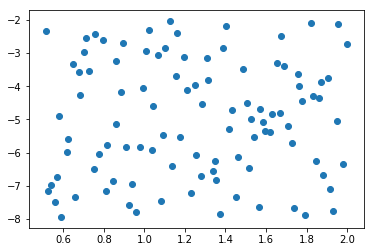

In [ ]:
plt.scatter(coords[0],coords[1])

In [ ]:
def run_yso_model( Tstar=None, logL_star=None, \
        logM_disk=None, logR_disk=None, h_0=None, logR_in=None, gamma=None, \
        beta=None, logM_env=None, logR_env=None, f_cav=None, ksi=None, \
        loga_max=None, p=None, incl=None):
    
    params = [Tstar,logL_star,logM_disk,logR_disk,h_0,logR_in,\
          gamma,beta,logM_env,logR_env,f_cav,ksi,loga_max,p,incl]

    # Set up the dust properties.

    dust_gen = dust.DustGenerator(dust.__path__[0]+"/data/diana_wice.hdf5")
    ddust = dust_gen(10.**loga_max / 1e4, p)
    env_dust_gen = dust.DustGenerator(dust.__path__[0]+\
            "/data/diana_wice.hdf5")
    edust = env_dust_gen(1.0e-4, 3.5)

    # Calculate alpha correctly.

    alpha = gamma + beta

    # Fix the scale height of the disk.

    h_0 *= (10.**logR_disk)**beta

    # Set up the model.

    model = modeling.YSOModel()
    model.add_star(luminosity=10.**logL_star, temperature=Tstar)
    model.set_spherical_grid(10.**logR_in, 10.**logR_env, 100, 101, 2, \
            code="radmc3d")
    model.add_pringle_disk(mass=10.**logM_disk, rmin=10.**logR_in, \
            rmax=10.**logR_disk, plrho=alpha, h0=h_0, plh=beta, dust=ddust)
    model.add_ulrich_envelope(mass=10.**logM_env, rmin=10.**logR_in, \
            rmax=10.**logR_env, cavpl=ksi, cavrfact=f_cav, dust=edust)
    model.grid.set_wavelength_grid(0.1,1.0e5,500,log=True)
    
    print("finished setting up model, now running thermal simulation")

    # Run the thermal simulation
    model.run_thermal(code="radmc3d", nphot=1e6, \
            modified_random_walk=True, verbose=False, setthreads=20, \
            timelimit=10800)
    
    print("finished running thermal simulation, now running SED")
    t2=time()
    
    # Run the SED.

    model.set_camera_wavelength(np.logspace(-1.,4.,500))
    model.run_sed(name="SED", nphot=1e5, loadlambda=True, incl=incl, \
            pa=0., dpc=140., code="radmc3d", camera_scatsrc_allfreq=True, \
            verbose=False, setthreads=20)
    
    filename=""
    for i in range(len(param_names)):
        filename+=param_names[i]+"_"
        filename+=str(params[i])+"_"
    filename=filename[:-1]
    filename+=".hdf5"
    print("finished running "+filename[0:40]+"... in %0.3fs" % (time() - t2))
    
    # Write out the file.
    model.write_yso("../../grid/grid78/"+filename)

In [ ]:
pars=bases

In [ ]:
for i in range(len(coords[0])):
    t0=time()
    run_yso_model(Tstar=pars[0], logL_star=pars[1], \
            logM_disk=pars[2], logR_disk=pars[3], h_0=pars[4], logR_in=pars[5], gamma=pars[6], \
            beta=coords[0][i], logM_env=coords[1][i], logR_env=pars[9], f_cav=pars[10], ksi=pars[11], \
            loga_max=pars[12], p=pars[13], incl=pars[14])
    print("finished running SED #"+str(i)+" in %0.3fs" % (time() - t0))

finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 488.770s
finished running SED #0 in 511.574s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 513.899s
finished running SED #1 in 542.756s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 586.866s
finished running SED #2 in 633.645s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 633.723s
finished running SED #3 in 675.496s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished 

finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 631.140s
finished running SED #37 in 667.822s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 595.986s
finished running SED #38 in 641.165s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 425.570s
finished running SED #39 in 532.540s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 502.386s
finished running SED #40 in 540.105s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in

finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 343.236s
finished running SED #74 in 595.770s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 657.357s
finished running SED #75 in 707.047s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 352.008s
finished running SED #76 in 370.329s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 329.215s
finished running SED #77 in 344.313s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 651.862s
finished running SED #78 in 700.497s
finish

In [ ]:
#r=[ranges[9],ranges[10]]
#coords=np.array(lhsmdu.sample(2,100))
#coords=coords*np.array([r[0][1]-r[0][0],r[1][1]-r[1][0]])[:,np.newaxis]
#coords+=np.array([r[0][0],r[1][0]])[:,np.newaxis]

#with open('../../grid_metadata/910_coords.txt', 'wb') as fp:
#    pickle.dump(coords, fp)

with open ('../../grid_metadata/910_coords.txt', 'rb') as fp:
    coords = pickle.load(fp)

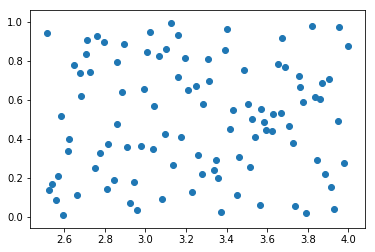

In [ ]:
plt.scatter(coords[0],coords[1])

In [ ]:
def run_yso_model( Tstar=None, logL_star=None, \
        logM_disk=None, logR_disk=None, h_0=None, logR_in=None, gamma=None, \
        beta=None, logM_env=None, logR_env=None, f_cav=None, ksi=None, \
        loga_max=None, p=None, incl=None):
    
    params = [Tstar,logL_star,logM_disk,logR_disk,h_0,logR_in,\
          gamma,beta,logM_env,logR_env,f_cav,ksi,loga_max,p,incl]

    # Set up the dust properties.

    dust_gen = dust.DustGenerator(dust.__path__[0]+"/data/diana_wice.hdf5")
    ddust = dust_gen(10.**loga_max / 1e4, p)
    env_dust_gen = dust.DustGenerator(dust.__path__[0]+\
            "/data/diana_wice.hdf5")
    edust = env_dust_gen(1.0e-4, 3.5)

    # Calculate alpha correctly.

    alpha = gamma + beta

    # Fix the scale height of the disk.

    h_0 *= (10.**logR_disk)**beta

    # Set up the model.

    model = modeling.YSOModel()
    model.add_star(luminosity=10.**logL_star, temperature=Tstar)
    model.set_spherical_grid(10.**logR_in, 10.**logR_env, 100, 101, 2, \
            code="radmc3d")
    model.add_pringle_disk(mass=10.**logM_disk, rmin=10.**logR_in, \
            rmax=10.**logR_disk, plrho=alpha, h0=h_0, plh=beta, dust=ddust)
    model.add_ulrich_envelope(mass=10.**logM_env, rmin=10.**logR_in, \
            rmax=10.**logR_env, cavpl=ksi, cavrfact=f_cav, dust=edust)
    model.grid.set_wavelength_grid(0.1,1.0e5,500,log=True)
    
    print("finished setting up model, now running thermal simulation")

    # Run the thermal simulation
    model.run_thermal(code="radmc3d", nphot=1e6, \
            modified_random_walk=True, verbose=False, setthreads=15, \
            timelimit=10800)
    
    print("finished running thermal simulation, now running SED")
    t2=time()
    
    # Run the SED.

    model.set_camera_wavelength(np.logspace(-1.,4.,500))
    model.run_sed(name="SED", nphot=1e5, loadlambda=True, incl=incl, \
            pa=0., dpc=140., code="radmc3d", camera_scatsrc_allfreq=True, \
            verbose=False, setthreads=15)
    
    filename=""
    for i in range(len(param_names)):
        filename+=param_names[i]+"_"
        filename+=str(params[i])+"_"
    filename=filename[:-1]
    filename+=".hdf5"
    print("finished running "+filename[0:40]+"... in %0.3fs" % (time() - t2))
    
    # Write out the file.
    model.write_yso("../../grid/grid910/"+filename)

In [ ]:
for i in range(len(coords[0])):
    t0=time()
    run_yso_model(Tstar=pars[0], logL_star=pars[1], \
            logM_disk=pars[2], logR_disk=pars[3], h_0=pars[4], logR_in=pars[5], gamma=pars[6], \
            beta=pars[7], logM_env=pars[8], logR_env=coords[0][i], f_cav=coords[1][i], ksi=pars[11], \
            loga_max=pars[12], p=pars[13], incl=pars[14])
    print("finished running SED #"+str(i)+" in %0.3fs" % (time() - t0))

finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 514.562s
finished running SED #0 in 559.277s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 477.923s
finished running SED #1 in 519.952s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 460.775s
finished running SED #2 in 500.667s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 442.641s
finished running SED #3 in 481.111s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished 

finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 435.185s
finished running SED #37 in 473.703s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 437.755s
finished running SED #38 in 476.417s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 492.510s
finished running SED #39 in 535.585s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in 447.306s
finished running SED #40 in 486.286s
finished setting up model, now running thermal simulation
finished running thermal simulation, now running SED
finished running Tstar_4000.0_logLstar_1.0_logMdisk_-5.0_... in